In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras


In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\bbuser\Downloads\heart.csv")  # UCI Heart Disease datase
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [3]:
# 2. Features/target split
X = df.drop("target", axis=1)
y = df["target"]

In [4]:
# 3. Convert to numeric (force)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors="coerce")

In [5]:
# 4. Fill NaNs with median
X = X.fillna(X.median())

In [6]:
# 5. One-hot encode categorical features (adjust columns if needed)
categorical = ["sex", "cp", "thal", "slope", "ca"]
for col in categorical:
    if col in X.columns:
        X[col] = X[col].astype("category")
X = pd.get_dummies(X, columns=[c for c in categorical if c in X.columns], drop_first=True)


In [7]:
# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
# 7. Define scalers
scalers = {
    "raw": None,
    "standard": StandardScaler(),
    "minmax": MinMaxScaler()
}

In [9]:
# 8. Build NN function
def build_model(input_dim, lr=0.001):
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

results = {}

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
RAW → Acc: 0.849, Prec: 0.814, Rec: 0.914, F1: 0.861
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
STANDARD → Acc: 0.985, Prec: 0.981, Rec: 0.990, F1: 0.986
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
MINMAX → Acc: 0.941, Prec: 0.943, Rec: 0.943, F1: 0.943


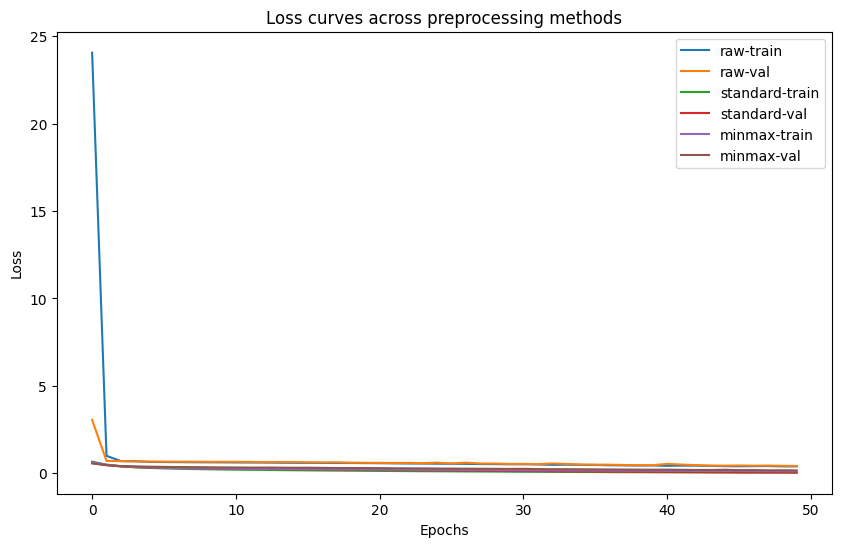

In [10]:
# 9. Train models with different preprocessing
for name, scaler in scalers.items():
    # Scale or use raw
    if scaler:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled, X_test_scaled = X_train.values, X_test.values

    # ✅ Ensure float32 arrays
    X_train_scaled = np.asarray(X_train_scaled).astype("float32")
    X_test_scaled = np.asarray(X_test_scaled).astype("float32")
    y_train_arr = np.asarray(y_train).astype("float32")
    y_test_arr = np.asarray(y_test).astype("float32")

    # Build and train
    model = build_model(X_train_scaled.shape[1])
    history = model.fit(
        X_train_scaled, y_train_arr,
        validation_split=0.2,
        epochs=50,
        batch_size=16,
        verbose=0
    )

    # Evaluate
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    acc = accuracy_score(y_test_arr, y_pred)
    prec = precision_score(y_test_arr, y_pred)
    rec = recall_score(y_test_arr, y_pred)
    f1 = f1_score(y_test_arr, y_pred)

    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "history": history
    }
    print(f"{name.upper()} → Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}")

# 10. Plot loss curves
plt.figure(figsize=(10,6))
for name, res in results.items():
    plt.plot(res["history"].history["loss"], label=f"{name}-train")
    plt.plot(res["history"].history["val_loss"], label=f"{name}-val")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss curves across preprocessing methods")
plt.show()